# H&M Fashion | EDA | H&M Personalized Fashion Recommendations
Hello everyone! In this my new notebook we are going to look through [H&M Personalized Fashion Recommendations](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations) Prediction Competition.

#### Acknowledgements 😍
My acknowledgments are given to:
* [GABRIEL PREDA. H&M EDA and Prediction](https://www.kaggle.com/gpreda/h-m-eda-and-prediction)

#### About 👚
H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. In this competition, H&M Group invites you to develop product recommendations based on data from previous transactions, as well as from customer and product meta data.

# 1. Import libraries 📚
Here we import libraries that will be used.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 2. Read data 📖

In [2]:
total_folders = 0
total_files = 0

folder_info = []
images_names = []

path = "../input/h-and-m-personalized-fashion-recommendations"

for base, dirs, files in tqdm(os.walk(path)):
    for directories in dirs:
        folder_info.append((directories, 
                            len(os.listdir(os.path.join(base, directories)))))
        total_folders = total_folders + 1
    
    for _files in files:
        total_files = total_files + 1
        if (len(_files.split(".jpg"))==2):
            images_names.append(_files.split(".jpg")[0])

88it [01:07,  1.31it/s]


After that we can check the final reading result:

In [3]:
print(f"• Total number of folders: {total_folders}")
print(f"• Total number of files: {total_files}")

• Total number of folders: 87
• Total number of files: 105104


In [4]:
folder_info_df = pd.DataFrame(folder_info, 
                              columns=["folder", 
                                       "files count"])

folder_info_df.sort_values(["files count"], ascending=False).head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,folder,files count
71,069,4187
45,073,3438
31,062,3361
36,068,3313
26,070,3309


In [5]:
articles_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
sample_submission_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")

transactions_train_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

After that, we can check, what we've read:

In [6]:
# articles_df
articles_df.head(3).style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [7]:
# customers_df
customers_df.head(3).style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,nan,nan,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,nan,nan,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,nan,nan,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc


In [8]:
# sample_submission_df
# prediction in sample submission is a sequence of article ids (max 12 article ids)
sample_submission_df.head(3).style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001


In [9]:
# transactions_train_df
transactions_train_df.head(3).style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2


# 3. Feature engineering 💻
***Transactions table*** is the train data. It contains customer_id and article_id, which are foreign keys for the customer and articles tables. Also, Transactions also contains sales_channel_id.

Here we can **check missing data, count unique values** etc.

In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return tt

Here we can look through missing data in different files.

In the **articles_df**, the only missing data is for the detailed description of the article (0.4% missing data).

In the **cutomers_df**, only *customer_id* and *postal_code* are completely filled. *Age*, *fashion_news_frequency* have around 1% misssing data, *FN* has 65% missing and *Active* has 66% missing data.

In the **transactions_train_df**, there is no missing data.

In [11]:
missing_data(articles_df).head(7).style.set_properties(**{'background-color': 'rgba(245, 181, 152,.5)'})

,Total,Percent
detail_desc,416,0.394156
perceived_colour_master_name,0,0.000000
garment_group_name,0,0.000000
garment_group_no,0,0.000000
section_name,0,0.000000
section_no,0,0.000000
index_group_name,0,0.000000


In [12]:
missing_data(customers_df).style.set_properties(**{'background-color': 'rgba(245, 245, 152,.5)'})

,Total,Percent
Active,907576,66.150819
FN,895050,65.237831
fashion_news_frequency,16009,1.166854
age,15861,1.156066
club_member_status,6062,0.441843
customer_id,0,0.000000
postal_code,0,0.000000


In [13]:
missing_data(transactions_train_df).style.set_properties(**{'background-color': 'rgba(152, 243, 245,.5)'})

,Total,Percent
t_dat,0,0.000000
customer_id,0,0.000000
article_id,0,0.000000
price,0,0.000000
sales_channel_id,0,0.000000


After that we can check **unique values**:

In [14]:
unique_values(articles_df).head(5).style.set_properties(**{'background-color': 'rgba(145, 178, 227,.5)'})

,Total,Uniques
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131


In [15]:
unique_values(customers_df).head(5).style.set_properties(**{'background-color': 'rgba(130, 126, 230,.5)'})

,Total,Uniques
customer_id,1371980,1371980
FN,476930,1
Active,464404,1
club_member_status,1365918,3
fashion_news_frequency,1355971,4


In [16]:
unique_values(transactions_train_df).head(5).style.set_properties(**{'background-color': 'rgba(188, 126, 230,.5)'})

,Total,Uniques
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


We can see that **not all** the customers in customer data are appearing as having transactions in transaction train data. 
**Moreover,** not all articles are represented in this data. 

It is **interesting** that the number of different prices is quite small, out of 31.7M transactions, and for 1.3M customers, buying 104K different articles. Same for the dates, there are only 734 different dates. 

# 4. Data visualisations. Articles Data 📊

In [17]:
def pie_chart(df, col_values, labels, ax, color, title):
    n_classes = len(df)
    explode = (0.1,) * n_classes # explode for 0.1 each slice
    ax.pie(df[col_values],
           colors=color, 
           explode=explode,
           labels=df[labels],
           shadow=True)
    ax.set_title(title, fontsize=16)
    
def bar_plot(df, col_x, col_y, ax, color, title):
    ax.bar(x=df[col_x],
           height=df[col_y],
           color=color)
    ax.set_title(title, fontsize=16) 
    plt.xticks(rotation=90)

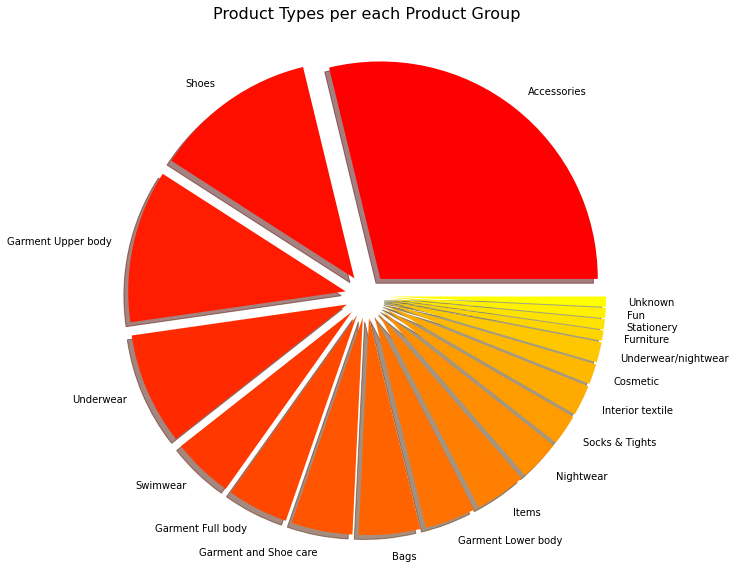

In [18]:
temp = articles_df.groupby(["product_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({'Product Group': temp.index,'Product Types': temp.values})
df = df.sort_values(['Product Types'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
color = plt.cm.autumn(np.linspace(0, 1, len(df)))

pie_chart(df,
          'Product Types', 
          'Product Group',
          axes, 
          color,  
          "Product Types per each Product Group")  

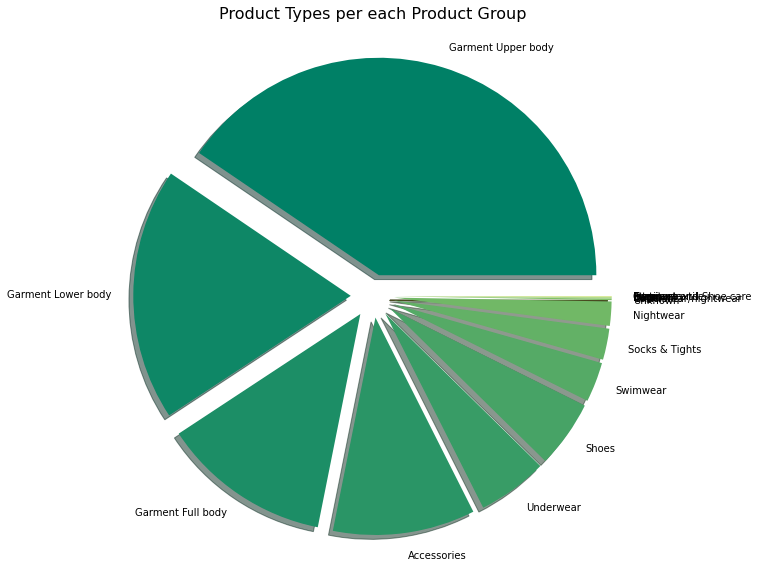

In [19]:
temp = articles_df.groupby(["product_group_name"])["article_id"].nunique()
df = pd.DataFrame({'Product Group': temp.index,'Articles': temp.values})
df = df.sort_values(['Articles'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
color = plt.cm.summer(np.linspace(0, 1, len(df)))

pie_chart(df,
          'Articles', 
          'Product Group',
          axes, 
          color,  
          "Product Types per each Product Group")  

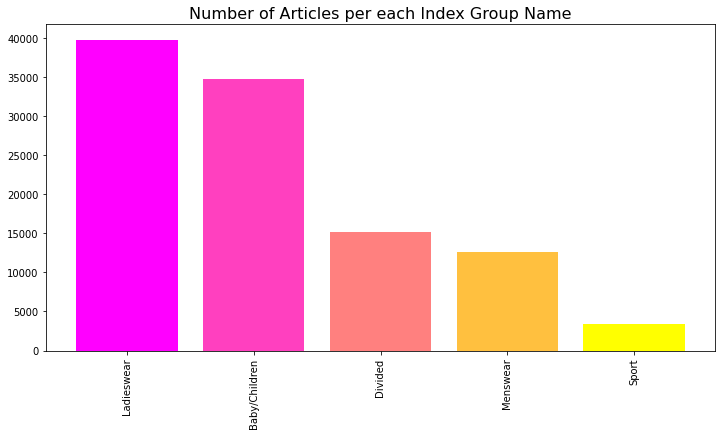

In [20]:
temp = articles_df.groupby(["index_group_name"])["article_id"].nunique()
df = pd.DataFrame({'Index Group Name': temp.index,'Articles': temp.values})
df = df.sort_values(['Articles'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
color = plt.cm.spring(np.linspace(0, 1, len(df)))

bar_plot(df,
         'Index Group Name',
         'Articles',
         axes, 
         color, 
         "Number of Articles per each Index Group Name")


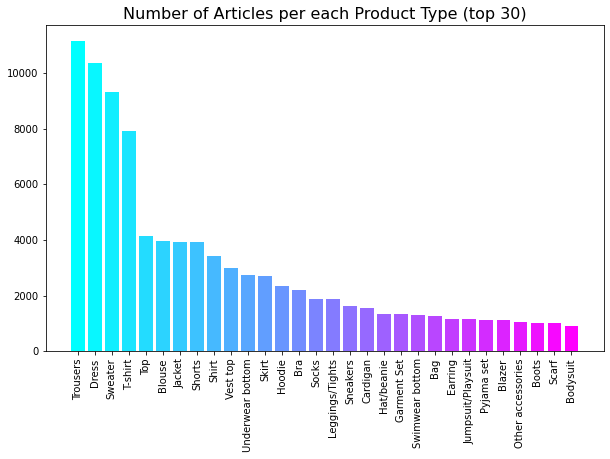

In [21]:
temp = articles_df.groupby(["product_type_name"])["article_id"].nunique()
df = pd.DataFrame({'Product Type': temp.index,'Articles': temp.values})
total_types = len(df['Product Type'].unique())
df = df.sort_values(['Articles'], ascending=False)[0:30]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
color = plt.cm.cool(np.linspace(0, 1, len(df)))

bar_plot(df,
         'Product Type',
         'Articles',
         axes, 
         color, 
         "Number of Articles per each Product Type (top 30)")


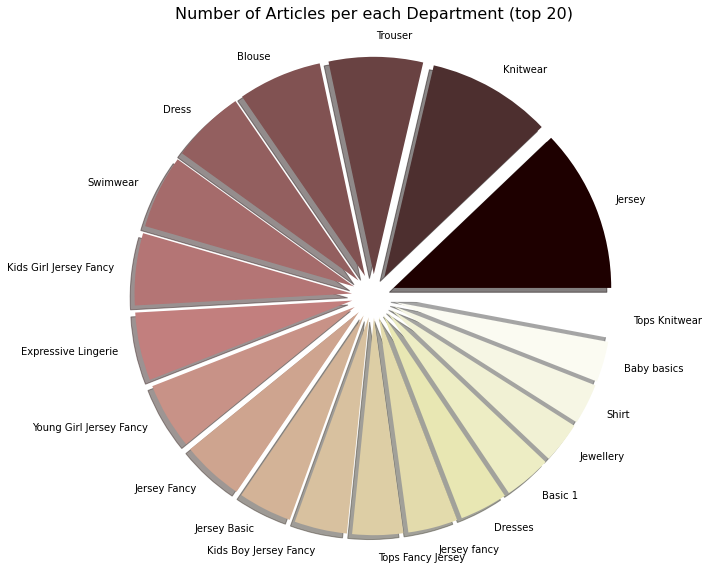

In [22]:
temp = articles_df.groupby(["department_name"])["article_id"].nunique()
df = pd.DataFrame({'Department Name': temp.index,'Articles': temp.values})
total_depts = len(df['Department Name'].unique())
df = df.sort_values(['Articles'], ascending=False).head(20)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
color = plt.cm.pink(np.linspace(0, 1, len(df)))

pie_chart(df,
          'Articles', 
          'Department Name',
          axes, 
          color,  
          "Number of Articles per each Department (top 20)")  

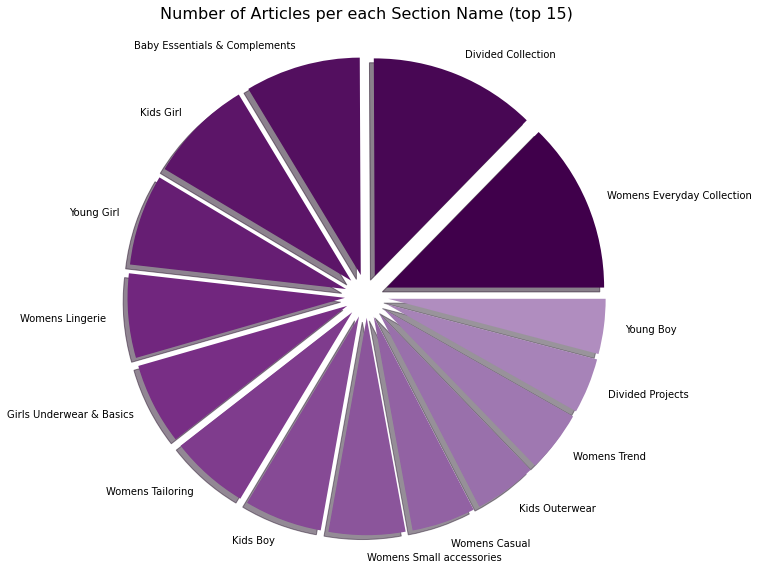

In [23]:
temp = articles_df.groupby(["section_name"])["article_id"].nunique()
df = pd.DataFrame({'Section Name': temp.index,'Articles': temp.values})
df = df.sort_values(['Articles'], ascending=False)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
color = plt.cm.PRGn(np.linspace(0, 1, len(df)))

pie_chart(df.head(15),
          'Articles', 
          'Section Name',
          axes, 
          color,  
          "Number of Articles per each Section Name (top 15)")  


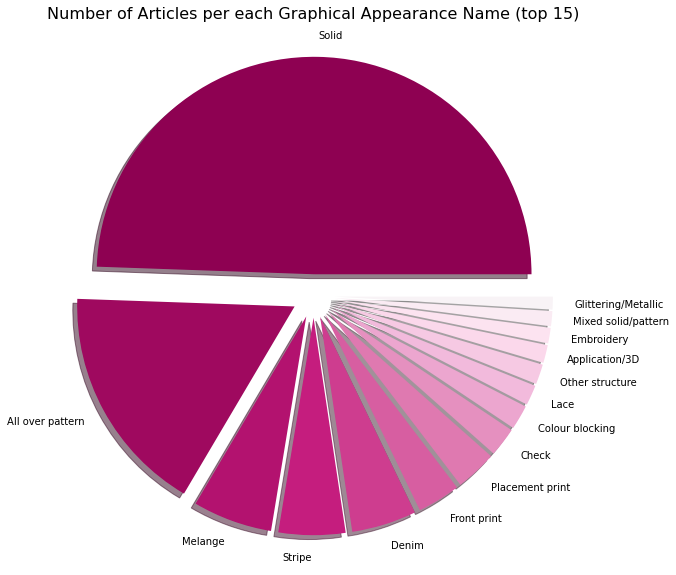

In [24]:
temp = articles_df.groupby(["graphical_appearance_name"])["article_id"].nunique()
df = pd.DataFrame({'Graphical Appearance Name': temp.index,'Articles': temp.values})
df = df.sort_values(['Articles'], ascending=False).head(50)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
color = plt.cm.PiYG(np.linspace(0, 1, len(df)))

pie_chart(df.head(15),
          'Articles', 
          'Graphical Appearance Name',
          axes, 
          color,  
          "Number of Articles per each Graphical Appearance Name (top 15)")  

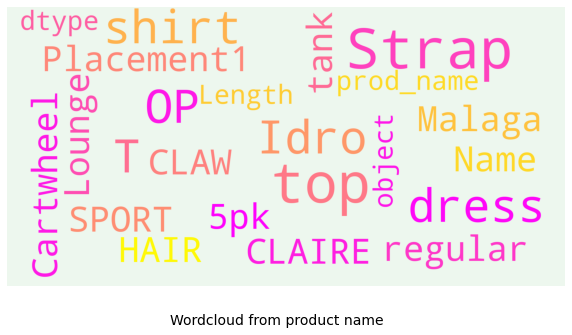

In [25]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='#edf7ee',
                          stopwords=stopwords,
                          max_words=400,
                          max_font_size=40, 
                          scale=5,
                          colormap="spring",
                          random_state=1).generate(str(data))

    
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
    
    
show_wordcloud(articles_df["prod_name"], "Wordcloud from product name")

# 5. Data visualisations. Customers Data 📊

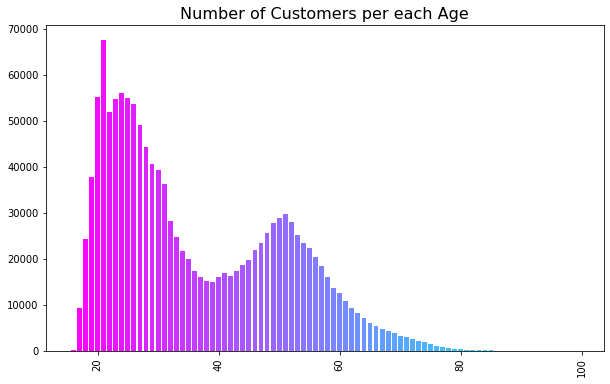

In [26]:
temp = customers_df.groupby(["age"])["customer_id"].count()
df = pd.DataFrame({'Age': temp.index,'Customers': temp.values})
df = df.sort_values(['Age'], ascending=False)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
color = plt.cm.cool(np.linspace(0, 1, len(df)))

bar_plot(df,
         'Age',
         'Customers',
         axes, 
         color, 
         "Number of Customers per each Age")

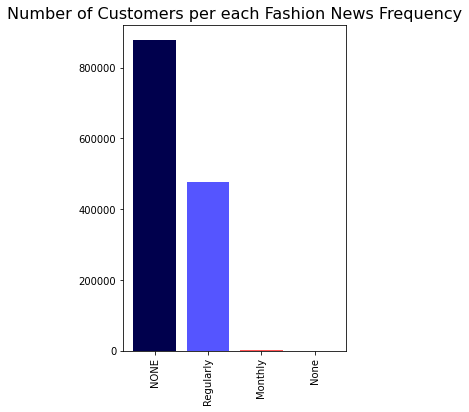

In [27]:
temp = customers_df.groupby(["fashion_news_frequency"])["customer_id"].count()
df = pd.DataFrame({'Fashion News Frequency': temp.index,'Customers': temp.values})
df = df.sort_values(['Customers'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,6))
color = plt.cm.seismic(np.linspace(0, 1, len(df)))

bar_plot(df,
         'Fashion News Frequency',
         'Customers',
         axes, 
         color, 
         "Number of Customers per each Fashion News Frequency")

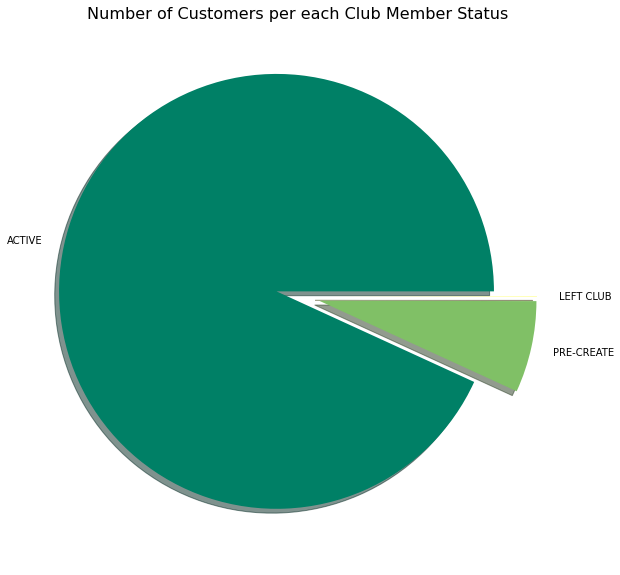

In [28]:
temp = customers_df.groupby(["club_member_status"])["customer_id"].count()
df = pd.DataFrame({'Club Member Status': temp.index,'Customers': temp.values})
df = df.sort_values(['Customers'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
color = plt.cm.summer(np.linspace(0, 1, len(df)))

pie_chart(df.head(15),
          'Customers', 
          'Club Member Status',
          axes, 
          color,  
          "Number of Customers per each Club Member Status") 

# 6. Data visualisations. Transactions Data 📊

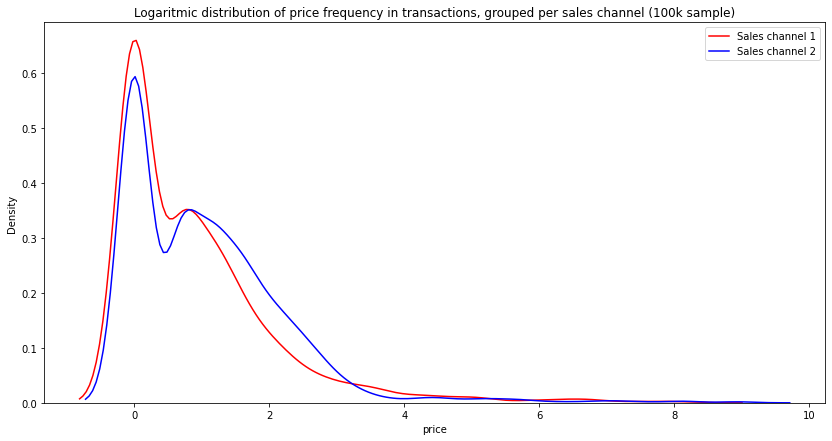

In [29]:
df = transactions_train_df.sample(100_000)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.kdeplot(np.log(df.loc[df["sales_channel_id"]==1].price.value_counts()),
           color="red")
sns.kdeplot(np.log(df.loc[df["sales_channel_id"]==2].price.value_counts()),
           color="blue")

ax.legend(labels=['Sales channel 1', 
                  'Sales channel 2'])

plt.title("Logaritmic distribution of price frequency \
in transactions, grouped per sales channel (100k sample)")

plt.show()

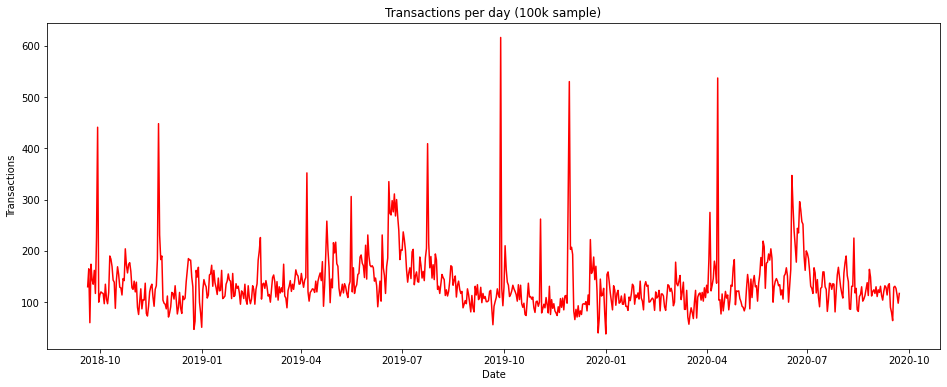

In [30]:
df = transactions_train_df.sample(100_000).groupby(["t_dat"])["article_id"].count().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.columns = ["Date", "Transactions"]

fig, ax = plt.subplots(1, 1, figsize=(16,6))
plt.plot(df["Date"], df["Transactions"], color="red")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title(f"Transactions per day (100k sample)")
plt.show()

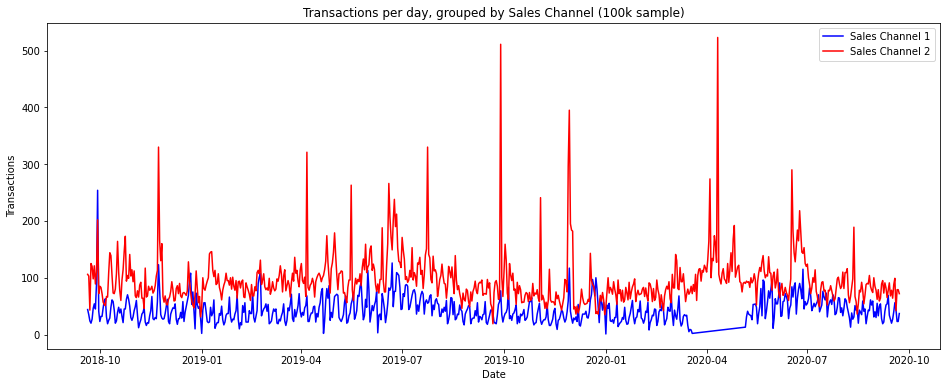

In [31]:
df = transactions_train_df.sample(100_000).groupby(["t_dat", "sales_channel_id"])["article_id"].count().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df.columns = ["Date", "Sales Channel Id", "Transactions"]

fig, ax = plt.subplots(1, 1, figsize=(16,6))
g1 = ax.plot(df.loc[df["Sales Channel Id"]==1, "Date"], 
             df.loc[df["Sales Channel Id"]==1, 
                    "Transactions"], 
             label="Sales Channel 1", 
             color="Blue")

g2 = ax.plot(df.loc[df["Sales Channel Id"]==2, "Date"], 
             df.loc[df["Sales Channel Id"]==2, 
                    "Transactions"], 
             label="Sales Channel 2", 
             color="Red")

plt.xlabel("Date")
plt.ylabel("Transactions")
ax.legend()
plt.title(f"Transactions per day, grouped by Sales Channel (100k sample)")
plt.show()

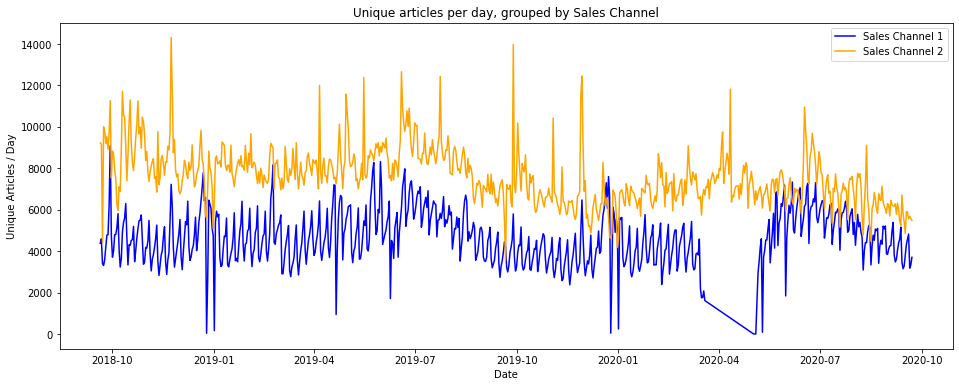

In [32]:
df = transactions_train_df.groupby(["t_dat", "sales_channel_id"])["article_id"].nunique().reset_index()
df["t_dat"] = df["t_dat"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.columns = ["Date", "Sales Channel Id", "Unique Articles"]

fig, ax = plt.subplots(1, 1, figsize=(16,6))
g1 = ax.plot(df.loc[df["Sales Channel Id"]==1, 
                    "Date"], 
             df.loc[df["Sales Channel Id"]==1, 
                    "Unique Articles"], 
             label="Sales Channel 1", 
             color="Blue")

g2 = ax.plot(df.loc[df["Sales Channel Id"]==2, 
                    "Date"], 
             df.loc[df["Sales Channel Id"]==2, 
                    "Unique Articles"], 
             label="Sales Channel 2", 
             color="Orange")

plt.xlabel("Date")
plt.ylabel("Unique Articles / Day")
ax.legend()
plt.title(f"Unique articles per day, grouped by Sales Channel")
plt.show()

# 7. Data visualisations. Image Data 📊

In [33]:
image_name_df = pd.DataFrame(images_names, columns = ["image_name"])
image_name_df["article_id"] = image_name_df["image_name"].apply(lambda x: int(x[1:]))
image_name_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,image_name,article_id
0,0570177001,570177001
1,0575944002,575944002
2,0576129001,576129001
3,0570806001,570806001
4,0572155001,572155001


In [34]:
image_article_df = articles_df[["article_id", 
                                "product_code", 
                                "product_group_name", 
                                "product_type_name"]].merge(image_name_df, 
                                                            on=["article_id"], 
                                                            how="left")
image_article_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,article_id,product_code,product_group_name,product_type_name,image_name
0,108775015,108775,Garment Upper body,Vest top,0108775015
1,108775044,108775,Garment Upper body,Vest top,0108775044
2,108775051,108775,Garment Upper body,Vest top,0108775051
3,110065001,110065,Underwear,Bra,0110065001
4,110065002,110065,Underwear,Bra,0110065002


In [35]:
# products without images
article_no_image_df = image_article_df.loc[image_article_df.image_name.isna()]
article_no_image_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,article_id,product_code,product_group_name,product_type_name,image_name
88,174057028,174057,Nightwear,Pyjama jumpsuit/playsuit,nan
117,179208001,179208,Garment Lower body,Leggings/Tights,nan
258,212042043,212042,Shoes,Sneakers,nan
259,212042066,212042,Shoes,Sneakers,nan
261,212629004,212629,Garment Full body,Dress,nan


Let's plot some image data.

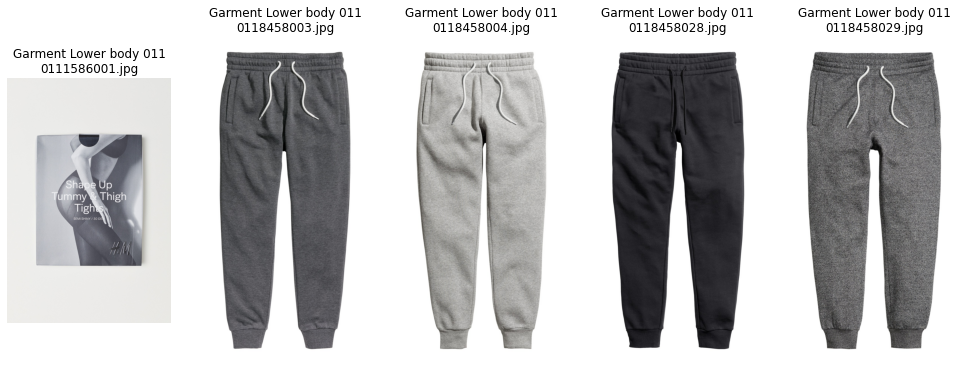

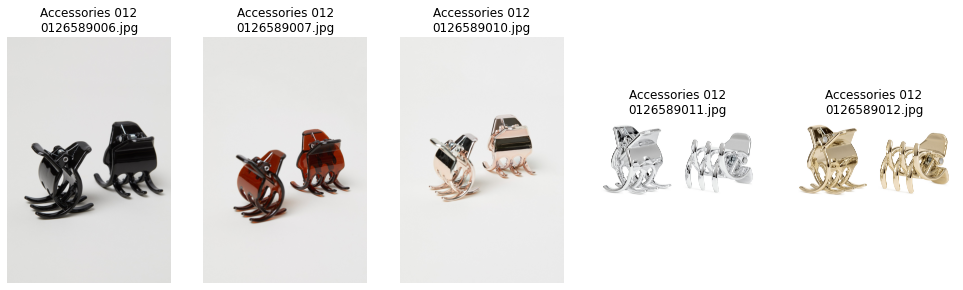

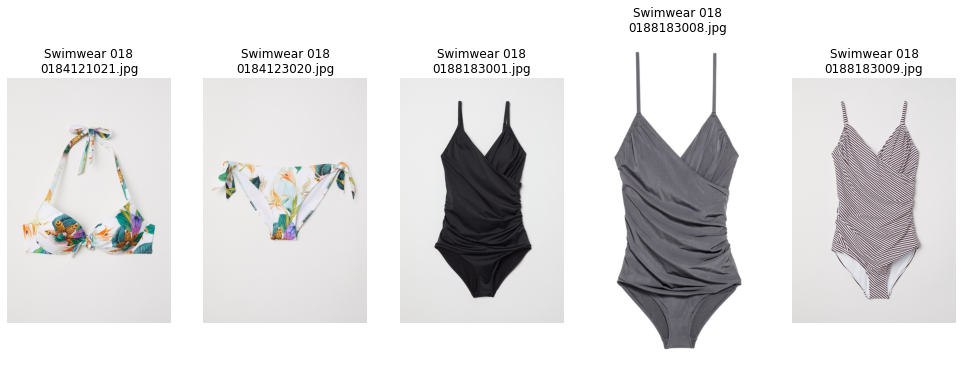

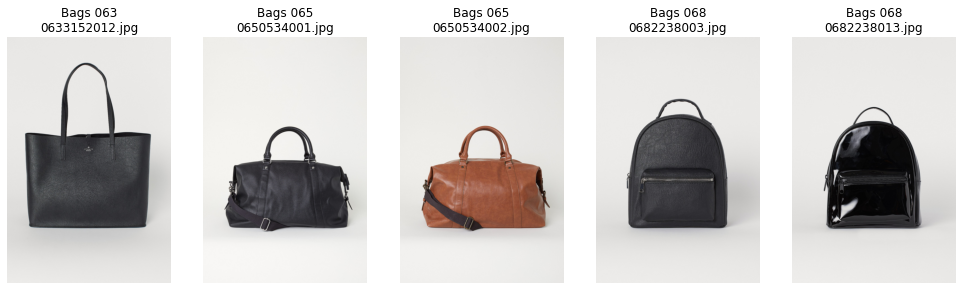

In [36]:
def plot_image_samples(image_article_df, product_group_name, cols=1, rows=-1):
    image_path = "../input/h-and-m-personalized-fashion-recommendations/images/"
    _df = image_article_df.loc[image_article_df.product_group_name==product_group_name]
    article_ids = _df.article_id.values[0:cols*rows]
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    for i in range(cols * rows):
        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(f"{product_group_name} {article_id[:3]}\n{article_id}.jpg")
        image = Image.open(f"{image_path}{article_id[:3]}/{article_id}.jpg")
        plt.imshow(image)
        
plot_image_samples(image_article_df, "Garment Lower body", 5, 1)
plot_image_samples(image_article_df, "Accessories", 5, 1)
plot_image_samples(image_article_df, "Swimwear", 5, 1)
plot_image_samples(image_article_df, "Bags", 5, 1)

# 8. Predictions ☂️
For this initial submission, I dediced to follow logic, that was described in article, that is give in anknowledgements:

* if there are articles for a certain client, pick the most recent buys;
* if there are not articles for a certain client, just pick the most frequently buyed articles.

In [37]:
transactions_train_df = transactions_train_df.sort_values(["customer_id", 
                                                           "t_dat"], 
                                                          ascending=False)
transactions_train_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,t_dat,customer_id,article_id,price,sales_channel_id
19867243,2019-12-04,ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241,806050001,0.084729,2
27806865,2020-06-22,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a,882810001,0.016932,1
25077914,2020-04-25,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a,866755002,0.050831,2
24375394,2020-04-09,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a,866755002,0.043203,2
24375395,2020-04-09,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a,840360003,0.013542,2


Let's capture first what are the most frequent recently bought articles.

In [38]:
last_date = transactions_train_df.t_dat.max()
print(last_date)
print(transactions_train_df.loc[transactions_train_df.t_dat==last_date].shape)
print()

most_frequent_articles = list(transactions_train_df.loc[transactions_train_df.t_dat==last_date].article_id.value_counts()[0:12].index)
art_list = []
for art in most_frequent_articles:
    art = "0"+str(art)
    art_list.append(art)
art_str = " ".join(art_list)
print("Frequent articles bought recently:", art_str, end="\n")

2020-09-22
(32866, 5)

Frequent articles bought recently: 0924243002 0751471001 0448509014 0918522001 0866731001 0714790020 0788575004 0915529005 0573085028 0918292001 0850917001 0928206001


In [39]:
agg_df = transactions_train_df.groupby(["customer_id"])["article_id"].agg(lambda x: str(x.values[0:12])[1:-1]).reset_index()

In [40]:
def padding_articles(x):
    if x:
        xl = x.split()
        x = []
        for xi in xl:
            x.append("0"+xi)
        dimm_x = len(x)
        if dimm_x < 12:
            x.extend(art_list[:12-dimm_x])
        return(" ".join(x))

In [41]:
agg_df["article_id"] = agg_df["article_id"].apply(lambda x: padding_articles(x))
print("Aggregated transaction history: ", agg_df.customer_id.nunique())
print("Submission sample: ", sample_submission_df.customer_id.nunique())

Aggregated transaction history:  1362281
Submission sample:  1371980


We'll replace the values in sample submission with the existent in aggregated transactions data and just let the default one otherwise.

In [42]:
sample_submission_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001


For the customers with missing articles, we simply replace with most frequent buyed articles in most recent days.

In [43]:
submission_df = agg_df.merge(sample_submission_df[["customer_id"]], how="right")
submission_df.columns = ["customer_id", "prediction"]
print(submission_df.shape)
submission_df.head().style.set_properties(**{'background-color': 'rgba(184,230,194,.5)'})

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0568601043 0841260003 0887593002 0890498002 0795440001 0859416011 0694736004 0785710001 0812683013 0785186005 0797065001 0797065001
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0826211002 0599580055 0599580055 0811835004 0811835004 0811835004 0811835004 0723529001 0559630026 0599580083 0811927004 0811927004
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0794321007 0858883002 0851400006 0750424014 0750424014 0870304002 0870304002 0852643001 0852643003 0727808001 0727808007 0723529001
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0742079001 0732413001 0924243002 0751471001 0448509014 0918522001 0866731001 0714790020 0788575004 0915529005 0573085028 0918292001
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0896152002 0730683050 0927530004 0791587015 0589440005 0827971001 0818320001 0399061015 0399061015 0698286003 0707704003 0634249005


In [44]:
print("Rows with missing data in submission: ", submission_df.loc[submission_df.prediction.isna()].shape[0])

Rows with missing data in submission:  9699


We replace the missing data with the most frequently bought articles, from recent days. We calculated it before.

In [45]:
submission_df.loc[submission_df.prediction.isna(), ["prediction"]] = art_str
print("Rows with missing data in submission: ", submission_df.loc[submission_df.prediction.isna()].shape[0])
submission_df.to_csv("submission.csv", index=False)

Rows with missing data in submission:  0


# 9. Conclusion 💖
Thank you for reading my new article! **If you liked it, please, make an upvote 💖**

My other articles:
* [House Prices Regression sklearn](https://www.kaggle.com/maricinnamon/house-prices-regression-sklearn)
* [Harry Potter Movies Dataset | Starter Notebook](https://www.kaggle.com/maricinnamon/harry-potter-movies-dataset-starter-notebook)
* [Automobile Customer Clustering (K-means & PCA)](https://www.kaggle.com/maricinnamon/automobile-customer-clustering-k-means-pca)